In [1]:
# Usado para ler arquivos, carregar código personalizado e ter acesso a outros recursos de sistema
import os
import sys

# Programação funcional e utilitários
import funcy as fp
import itertools

# Recursos para texto
import re

# Verificação de tipos
from typing import List

# Manipulação e análise dos dados
import numpy as np
import pandas as pd

# Manipulação e análise de texto
import fasttext

# Redução de Dimensionalidade e Análise de Similaridade
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax

# Recursos para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display

# Carregar, além de atualizar frequentemente, código personalizado disponível em ../src
%load_ext autoreload 
%autoreload 2
sys.path.append(os.path.abspath(os.path.pardir))
from src import settings
from src.utils.notebooks import display_side_by_side
from src.utils.experiments import set_dataset_split, extract_tokens, TAG_SPLIT_PATTERN
from src.utils.experiments import compute_multiclass_classification_metrics

# Configurações para a exibição de conteúdo do Pandas e das bibliotecas gráficas
%matplotlib inline 
sns.set(rc={'figure.figsize':(25,10)})
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 150)

# Análise de Estratégias para Valores Textuais

O objetivo deste notebook é analisar estratégias para se lidar com valores textuais. São 4 atributos textuais disponíveis, dos quais um possui apenas 6 valores (*category*) e os demais possuem textos mais longos, especialmente tags.

As categorias possuem duas formas difernetes de uso, conforme a etapa do projeto:
 - **Supervisionada**: funciona como o rótulo das instâncias, então deve ser processada com algo equivalente ao *LabelEncoder*.
 - **Não Supervisionada**: pode ser utilizada como *feature* para o modelo de intenção de busca. Nesse caso, espera-se trabalhar com uma de duas opções:
    - *One Hot Encoding*, para se ter 5 *features* no vetor de caracerísticas
    - Alguma variação de *target encoding* (e.g., *leave one out*, catboost ou *mean target encoding*). Nesse caso, o número de features adicionais dependerá do número de intenções de busca identificadas. Caso o número seja superior a 5, OHE pode ser a opção mais prática.
    
Para os 3 atributos com valores textuais mais longos, as abordagens propostas inicialmente são:
 - Usar o modelo tradicional de TF-IDF: pode ser usado em conjunto com *n-grams* para estabelecer sequência entre termos (pode ser útil para título e busca), mas parece ser mais suscetível a problemas com palavras ausentes do vocabulário. Provavelmente levará a um número maior de atributos no vetor de características, mas podem ser feitas podas ou redução de dimensionalidade.
 - Usar *embeddings*: se beneficia da variedade mais ampla de palavras a partir da qual o modelo foi criado, reduzindo o problema de palavras fora do vocabulário. A depender do algoritmo e as estratégias de criação do modelo, provavelmente já incorpora informações adicionais de contexto e relação entre as palavras. Tende a ter entre 300 e 768 atributos adicionais no vetor de cacterísticas, ainda que seja possível adotar estratégias de redução. 


## Carregamento dos Dados

Para analisar os dados e fazer algumas experimentações, as colunas com valores textuais serão recuperadas, assim como outras que auxiliam na experimentação (como a data de criação). Os dados utilizados se limitam ao conjunto de treinamento, mantendo o isolamento dos dados de teste.

In [2]:
columns_to_read = ['product_id', 'query', 'search_page', 'position', 'title', 'concatenated_tags', 'category', 'creation_date']

frame = pd.read_csv(os.path.join(settings.DATA_PATH, 'interim', 'training.csv'), usecols=columns_to_read)

Visualização da quantidade de registros e das informações disponíveis.

In [3]:
print(f'Registros: {len(frame)}.')

frame.head(10)

Registros: 32746.


product_id                                query  search_page  position  \
0    11394449                       espirito santo            2         6   
1    15534262                     cartao de visita            2         0   
2    15877252  medidas lencol para berco americano            1         6   
3    15917108                 adesivo box banheiro            3        38   
4     4336889                         dia dos pais            1        37   
5     7544556          arranjo de flores para mesa            1         9   
6    10869150             lembrancinha maternidade            5        18   
7    13193769                chaveiro dia dos pais            1        35   
8    13424151                  manta personalizada            1        20   
9    12595651                                 pais            1        28   

                                                  title  \
0                                Mandala Espírito Santo   
1                                      Cartão de Visita   
2                        Jogo de Lençol Berço Estampado   
3                               ADESIVO BOX DE BANHEIRO   
4                      Álbum de figurinhas dia dos pais   
5                         Arranjo de Flores - Orquidias   
6  Kit Aromarizador + sacola / Lembrancinha Maternidade   
7                                 chaveiro dia dos pais   
8       Manta para bebê personalizada de Nuvem com nome   
9                                  Chinelo Dia dos Pais   

                                                                                concatenated_tags  \
0                                                                                     mandala mdf   
1                                   cartao visita panfletos tag adesivos copos long drink canecas   
2                                                               t jogo lencol menino lencol berco   
3                                                                            adesivo box banheiro   
4                                                         albuns figurinhas pai lucas album fotos   
5                                                                                   mini arranjos   
6  bb lembrancinhas maternidade baby lembranca maternidade bebe conforto lembrancinha maternidade   
7                                                                                        dia pais   
8                                                     nascimento manta baby cha bebe vestido bebe   
9                                                                               sandalia dia pais   

         creation_date       category  
0  2015-11-14 19:42:12      Decoração  
1  2018-04-04 20:55:07    Papel e Cia  
2  2017-02-27 13:26:03           Bebê  
3  2017-05-09 13:18:38      Decoração  
4  2018-07-11 10:41:33  Lembrancinhas  
5  2016-04-22 13:34:16      Decoração  
6  2017-10-05 00:26:02  Lembrancinhas  
7  2018-07-04 12:47:49  Lembrancinhas  
8  2018-04-03 16:10:51           Bebê  
9  2018-06-25 23:23:14  Lembrancinhas

## Word2Vec (via FastTex)

Esta seção explora o uso de uma implementação [work2vec](https://arxiv.org/pdf/1802.06893.pdfhttps://arxiv.org/pdf/1802.06893.pdf) (W2V), criada e fornecida de forma prática pelo [FastText](https://fasttext.cc/). O modelo foi treinado utilizando informações da [Wikipédia e do Common Crawl](https://fasttext.cc/docs/en/crawl-vectors.htmlhttps://fasttext.cc/docs/en/crawl-vectors.html), tornando seu escopo amplo e o vocabulário diverso.

O modelo pré-treinado pode ser [acessado diretamente](https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.bin.gzhttps://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.bin.gz). O primeiro ponto de atenção com o modelo é o tamanho do arquivo do modelo pré-treinado: 4 GB compactado e 7 GB ao ser extraído. Ao carregar o modelo, é possível notar ao menos 4 GB de memória RAM adicionais utilizado. Isso pode não ser um ponto de atenção grande ao pensar no processamento em lote de produtos já registrados, mas pode ser um impeditivo ao considerar as tarefas de inferência que podem ser feitas para atividades como busca, recomendação e classificação e que podem exigir a execução em múltiplas instâncias ou contêineres. 

Apesar desse ponto de preocupação, pode-se utilizar outros modelos pré-treinados de *embeddings*, do W2V ou não. Além disso, a versão já utilizada pode ser [reduzida](https://fasttext.cc/docs/en/crawl-vectors.html#adapt-the-dimension). Como o processo pode requerer algumas etapas de processamento e avaliação, ela está sendo considerada fora do escopo.

In [4]:
ft_model = fasttext.load_model(os.path.join(settings.MODELS_PATH, 'cc.pt.300.bin'))

A biblioteca que permite o uso modelo faz a [tokenização das sentenças](https://fasttext.cc/docs/en/python-module.html#important-preprocessing-data--encoding-conventions) e as próprias características dos *embeddings* criados oferecem robustez quanto a palavras não conhecidas (seja por um erro de digitação ou por uso não frequente).  A exemplo disso, pode-se verificar a coerência de palavras semelhantes a uma determinada:

In [5]:
display_side_by_side(
    [pd.DataFrame(ft_model.get_nearest_neighbors('bicicletas', k=10), columns=['Similaridade', 'Palavra']),
     pd.DataFrame(ft_model.get_nearest_neighbors('bike', k=10), columns=['Similaridade', 'Palavra']),
     pd.DataFrame(ft_model.get_nearest_neighbors('magrela', k=10), columns=['Similaridade', 'Palavra'])],
    ['Bicicleta', 'Bike', 'Magrela']
)

Esse recurso de similaridade também pode servir para realizar a aumentação/correção de dados. Isto deve ser interessante para corrigir ou aumentar termos de busca ou tags.

A seguir, são feitos alguns experimentos de verificação direta de resultados de busca de conteúdo por similaridade. O primeiro passo é gerar os *embeddings* de sentenças para o atributo textual escolhido -- no caso, título.

In [6]:
search_frame = (
    frame
    .copy()
    [['title']]
    .assign(embedding=lambda f: f['title']
            .str
            .lower()
            .apply(ft_model.get_sentence_vector))
)

Tendo uma sentença de busca, faz-se sua codificação e, para os valores disponíveis para recuperação, pode-se fazer calcular uma medida de similaridade, como o cosseno, e ordenar os registros pelos maiores valores.

In [7]:
queries = ['caneca personalizada', 
           'sling',
           'canguru',
           'luminária',
           'luminária charuto'
          ]

for query in queries:
    # Codificar query
    query_embedding = ft_model.get_sentence_vector(query.lower())
    # Calcular a similaridade entre a consulta e os títulos
    search_frame['similarity'] = cosine_similarity(np.array([query_embedding]),
                                                   np.array(search_frame['embedding'].tolist())).squeeze()
    # Recuperar valores mais semelhantes
    display(HTML(f'<h4>Consulta: <strong>{query}</strong></h4>'))
    print('Resultados mais próximos:')
    display(search_frame
     .sort_values(by='similarity', ascending=False)
     .drop_duplicates('title')
     .head(10)
    )
    
del search_frame

Resultados mais próximos:


title  \
1331             Caneca personalizada   
15281            Caneca Personalizada   
6122             CANECA PERSONALIZADA   
10078  Caneca Porcelana Personalizada   
27059      Caneca Preta Personalizada   
12346   Caneca acrílica personalizada   
18439   Caneca Acrílica Personalizada   
22940   Caneca Acrílico Personalizada   
15771    Caneca Térmica Personalizada   
31625   Caneca Acrilico Personalizada   

                                                                                                                                                   embedding  \
1331   [-0.09059346, -0.034301315, 0.0607446, -0.020065779, -0.0066683497, -0.109594256, -0.072513424, -0.06625397, 0.07723059, -0.016256474, 0.039437402...   
15281  [-0.09059346, -0.034301315, 0.0607446, -0.020065779, -0.0066683497, -0.109594256, -0.072513424, -0.06625397, 0.07723059, -0.016256474, 0.039437402...   
6122   [-0.09059346, -0.034301315, 0.0607446, -0.020065779, -0.0066683497, -0.109594256, -0.072513424, -0.06625397, 0.07723059, -0.016256474, 0.039437402...   
10078  [-0.07069832, 0.0046982965, 0.047493562, -0.016157009, -0.008527473, -0.09306421, -0.048104625, -0.056342825, 0.06474261, -0.010103639, 0.05388523...   
27059  [-0.051833153, -0.01854288, 0.07233629, 0.016803812, -0.016112, -0.10689729, -0.056004763, -0.052474853, 0.041784555, -0.035726435, 0.046542794, 0...   
12346  [-0.061020236, -0.018148094, 0.057960864, -0.010853151, 0.002238702, -0.08773321, -0.06855093, -0.03380088, 0.039526537, -0.005547813, 0.026883181...   
18439  [-0.061020236, -0.018148094, 0.057960864, -0.010853151, 0.002238702, -0.08773321, -0.06855093, -0.03380088, 0.039526537, -0.005547813, 0.026883181...   
22940  [-0.07212547, -0.027883325, 0.068373695, -0.006781872, -0.006588269, -0.08047559, -0.06045576, -0.020821337, 0.048221037, -0.0020321584, 0.0415500...   
15771  [-0.05758532, -0.05803579, 0.05319626, -0.015243884, 0.009728219, -0.116347015, -0.06378813, -0.065472856, 0.045696612, -0.034639355, 0.04596258, ...   
31625  [-0.07470423, -0.030835252, 0.058524206, -0.0045872806, -0.008715605, -0.08522179, -0.07237088, -0.021820134, 0.061030313, 0.0034812894, 0.0516236...   

       similarity  
1331     1.000000  
15281    1.000000  
6122     1.000000  
10078    0.927673  
27059    0.923568  
12346    0.921367  
18439    0.921367  
22940    0.919942  
15771    0.918677  
31625    0.918476

Resultados mais próximos:


title  \
29573                     Sling bordado canguru   
2083   Wrap Sling Dry Fit (Para Carregar Bebês)   
15679                     Wrap Sling Preto Liso   
7691    Wrap Sling, Canguru Bebê, carregador de   
5322   Promoção Imperdível - Wrap Sling Canguru   
8132        Wrap Sling de Algodão, Frete Grátis   
5643            SLING EM MALHA - WRAP - CANGURU   
7204                                     Cueiro   
14113                                Manta Bebê   
8434                            casaquinho Bebê   

                                                                                                                                                   embedding  \
29573  [-0.0022852533, -0.016764294, 0.047316425, -0.09254758, 0.008633211, -0.06656324, 0.0024755634, 0.02586161, 0.031612847, -0.06510758, 0.020087196,...   
2083   [-0.021999316, -0.07976433, 0.05642091, -0.04046484, -0.056687914, -0.017304031, 0.01674196, 0.008481959, 0.0017362259, -0.029013097, 0.03341182, ...   
15679  [-0.016791565, -0.018664947, 0.06829013, -0.016645458, -0.00567169, -0.055515468, -0.0073864483, 0.025938105, -0.042988062, -0.029250674, 0.071795...   
7691   [0.0022705495, -0.058408108, 0.030930353, -0.030740067, -0.02776073, -0.042319622, 0.023423327, -0.0031987976, 0.009514097, -0.03324899, 0.0101285...   
5322   [-0.004674551, -0.03699492, 0.040862896, -0.032531597, -0.019630544, -0.048716754, 0.0046307053, -0.007966973, 0.001832119, -0.034110233, -0.01767...   
8132   [-0.0055482774, -0.06460292, 0.036452368, -0.040081266, -0.037070356, -0.05208096, -0.0067972164, 0.010406724, -0.0105856415, -0.03085742, -0.0030...   
5643   [0.001854015, -0.022504011, 0.041315883, -0.034231737, 0.0057458715, -0.03714917, -0.015401573, 0.01702277, 0.020516567, 0.005380968, 0.011238917,...   
7204   [0.032061525, -0.07596725, -0.024388548, -0.051855795, 0.00074434804, -0.036232326, 0.08344118, -0.02711079, 0.004848071, -0.03154694, 0.051804848...   
14113  [0.025320444, -0.043820426, 0.0188271, -0.101444334, -0.0040465463, -0.079622686, 0.025736105, 0.007664902, 0.016111504, -0.061543427, 0.065889105...   
8434   [-0.0082769375, -0.037745297, 0.03368908, -0.09610407, 0.018707091, -0.03252883, 0.044451933, 0.017179593, 0.04026343, -0.073243335, 0.06018559, -...   

       similarity  
29573    0.770731  
2083     0.667925  
15679    0.642037  
7691     0.630270  
5322     0.608842  
8132     0.588861  
5643     0.554420  
7204     0.552350  
14113    0.527003  
8434     0.521495

Resultados mais próximos:


title  \
29573                     Sling bordado canguru   
24576                CANGURU ERGONÔMICO FASHION   
7691    Wrap Sling, Canguru Bebê, carregador de   
3860   Promoção Imperdível - Wrap Sling Canguru   
26911                          Naninha elefante   
23767                              Macacão Urso   
26700                  COFRINHO URSO MARINHEIRO   
17639                        Elefante Amigurumi   
31455                        Elefante amigurumi   
31596         Chaveiro Almofada Urso Marinheiro   

                                                                                                                                                   embedding  \
29573  [-0.0022852533, -0.016764294, 0.047316425, -0.09254758, 0.008633211, -0.06656324, 0.0024755634, 0.02586161, 0.031612847, -0.06510758, 0.020087196,...   
24576  [0.03929396, 0.008816363, 0.02075677, -0.024711162, 0.007305559, -0.0816867, 0.01321266, 0.015083849, 0.050864264, -0.06546644, 0.009162754, 0.000...   
7691   [0.0022705495, -0.058408108, 0.030930353, -0.030740067, -0.02776073, -0.042319622, 0.023423327, -0.0031987976, 0.009514097, -0.03324899, 0.0101285...   
3860   [-0.004674551, -0.03699492, 0.040862896, -0.032531597, -0.019630544, -0.048716754, 0.0046307053, -0.007966973, 0.001832119, -0.034110233, -0.01767...   
26911  [0.011046937, 0.0033619124, -0.00611943, -0.06598573, -0.029326309, -0.031608716, 0.002005808, 0.014707606, 0.062039495, -0.03250232, -0.022037335...   
23767  [0.07128489, -0.03725581, 0.052576564, -0.06866731, 0.04185236, -0.039540626, 0.023113972, 0.008440241, 0.06437056, -0.07732297, -0.02167094, -0.0...   
26700  [0.09024654, -0.02673993, 0.01617107, -0.054171722, 0.044357426, -0.06176017, 0.036698114, -0.061884265, 0.08415711, -0.06473112, -0.03844531, -0....   
17639  [0.031643543, -0.013961498, 0.03251092, -0.06754263, 0.014548184, -0.02479055, 0.010469096, 0.024443945, 0.077148, -0.07218521, -0.058466677, -0.0...   
31455  [0.031643543, -0.013961498, 0.03251092, -0.06754263, 0.014548184, -0.02479055, 0.010469096, 0.024443945, 0.077148, -0.07218521, -0.058466677, -0.0...   
31596  [0.047662016, -0.036453594, 0.023674523, -0.0017213705, 0.0004439468, -0.065631896, 0.02938016, -0.024863323, 0.07335093, -0.0675108, -0.006504684...   

       similarity  
29573    0.741662  
24576    0.702678  
7691     0.640065  
3860     0.604368  
26911    0.570347  
23767    0.547082  
26700    0.542638  
17639    0.539341  
31455    0.539341  
31596    0.537172

Resultados mais próximos:


title  \
18599                       Luminária artesanal   
3758                            Luminária Nuvem   
2461                         Luminária Heineken   
25103                   Luminária Madeira Retrô   
5126               Luminária Decorativa Amarela   
20685                       Vela Mini Luminária   
13688             Vela Decorativa com luminária   
6337                             Luminária Hulk   
24869  Lustre Plafon Luminária Cristal Acrílico   
14367             luminária Pvc Borboleta Lilás   

                                                                                                                                                   embedding  \
18599  [-0.02170024, -0.010178967, 0.07418527, 0.006850457, 0.011529952, -0.082544014, 0.018527118, -0.05231946, 0.015703054, -0.05172264, 0.055290442, -...   
3758   [-0.04124187, -0.02229874, 0.059932828, -0.0068386886, -0.010755985, -0.07521786, -0.0065066293, 0.0149485, 0.063705295, -0.031864654, 0.070955604...   
2461   [-0.029981326, -0.020523777, 0.05752523, 0.028150225, 0.0047409767, -0.031100262, -0.021203842, -0.06607415, 0.040422823, -0.022326881, 0.04575206...   
25103  [0.0152739845, -0.017619401, 0.060587727, 0.027594155, -0.006825417, -0.06199832, 0.00933631, -0.032177355, 0.03647194, -0.038609482, 0.06466025, ...   
5126   [-0.019850098, -0.015410842, 0.048835825, 0.030448114, -0.023631206, -0.10288333, 0.026235543, -0.024905946, 0.015392657, -0.061861705, 0.04851865...   
20685  [-0.010087301, -0.021463372, 0.042717688, 0.061807968, -0.046435334, -0.0893307, 0.012179415, -0.057684623, -0.018539647, -0.052470006, 0.06252831...   
13688  [-0.015020618, -0.03617738, 0.04537362, 0.04620771, -0.022323249, -0.07617095, 0.037055116, -0.044229552, -0.008021592, -0.060404174, 0.067267306,...   
6337   [0.0119768325, -0.0020740414, 0.0013733841, -0.025508834, 0.0035497134, -0.025127746, -0.01892015, -0.012218602, 0.03289303, -0.02415745, 0.010119...   
24869  [-0.02397722, -0.015149036, 0.0553679, 0.029952062, -0.0020172144, -0.050457656, 0.016639853, 0.026021166, 0.022743398, -0.029580062, 0.0702398, -...   
14367  [-0.03009791, -0.048180122, 0.0335456, 0.016850274, -0.013238626, -0.063065544, -0.013928434, 0.015083392, 0.020805616, -0.038255222, 0.010414635,...   

       similarity  
18599    0.814827  
3758     0.806173  
2461     0.793466  
25103    0.788782  
5126     0.788538  
20685    0.785430  
13688    0.766307  
6337     0.750434  
24869    0.739219  
14367    0.732649

Resultados mais próximos:


title  \
20685                                Vela Mini Luminária   
18599                                Luminária artesanal   
13688                      Vela Decorativa com luminária   
25103                            Luminária Madeira Retrô   
2461                                  Luminária Heineken   
21887                      Luminária c/ vela led - papel   
20645  Luminária pendente artesanal garrafa Jack Daniels   
5126                        Luminária Decorativa Amarela   
4684                 Luminária Personalizada Fusca Verde   
24869           Lustre Plafon Luminária Cristal Acrílico   

                                                                                                                                                   embedding  \
20685  [-0.010087301, -0.021463372, 0.042717688, 0.061807968, -0.046435334, -0.0893307, 0.012179415, -0.057684623, -0.018539647, -0.052470006, 0.06252831...   
18599  [-0.02170024, -0.010178967, 0.07418527, 0.006850457, 0.011529952, -0.082544014, 0.018527118, -0.05231946, 0.015703054, -0.05172264, 0.055290442, -...   
13688  [-0.015020618, -0.03617738, 0.04537362, 0.04620771, -0.022323249, -0.07617095, 0.037055116, -0.044229552, -0.008021592, -0.060404174, 0.067267306,...   
25103  [0.0152739845, -0.017619401, 0.060587727, 0.027594155, -0.006825417, -0.06199832, 0.00933631, -0.032177355, 0.03647194, -0.038609482, 0.06466025, ...   
2461   [-0.029981326, -0.020523777, 0.05752523, 0.028150225, 0.0047409767, -0.031100262, -0.021203842, -0.06607415, 0.040422823, -0.022326881, 0.04575206...   
21887  [-0.02379595, -0.018410942, 0.04753528, 0.0492254, -0.013302616, -0.045232195, -0.0071159997, -0.013490352, -0.011233791, -0.020862317, 0.04165190...   
20645  [-0.00069459097, -0.03844168, 0.053395428, 0.016799696, 0.00046498826, -0.06792957, 0.024435494, -0.022436537, 0.03452574, -0.06244322, 0.04087120...   
5126   [-0.019850098, -0.015410842, 0.048835825, 0.030448114, -0.023631206, -0.10288333, 0.026235543, -0.024905946, 0.015392657, -0.061861705, 0.04851865...   
4684   [-0.027775353, -0.013972213, 0.052032933, 0.00026114425, 0.010932053, -0.082307085, -0.018370904, 0.011824488, 0.0025868816, -0.048351403, 0.06040...   
24869  [-0.02397722, -0.015149036, 0.0553679, 0.029952062, -0.0020172144, -0.050457656, 0.016639853, 0.026021166, 0.022743398, -0.029580062, 0.0702398, -...   

       similarity  
20685    0.746456  
18599    0.734720  
13688    0.713296  
25103    0.707806  
2461     0.705942  
21887    0.699048  
20645    0.693442  
5126     0.679269  
4684     0.679101  
24869    0.671326

Pelos resultados apresentados, é possível notar algum nível de similaridade semântica além da sintática. Ao buscar apenas por *sling*, quando não há mais títulos com a presença da palavra ocorrem outros resultados relacionados, como 'cueiro', 'manta bebê' e 'casaquinho bebê'. Quando a expressão utilizada foi 'canguru', a falta de palavras adicionais para caracterizar o contexto gera como resultado produtos que alternam entre ocorrências semelhantes ao produto relacionado a bebês e outros produtos envolvendo animais. 

## Verificar termos fora do vocabulário

A fim de confirmar o entendimento de que o uso do Word2Vec deve trazer o benefício de um vocabulário amplo, será feita uma nova simulação da separação de dados por faixa de tempo -- tendo como base a data de criação do produto -- e a recuperação de conteúdos que estariam ausentes em um vocabulário construído apenas com os dados do conjunto fornecido para o problema.

In [8]:
cut_off_period = '2018-05'
split_frame = set_dataset_split(frame, cut_off_period)

pseudo_training_frame = split_frame.loc[lambda f: f['group'] != 'test'].drop(columns=['group'])
pseudo_test_frame = split_frame.loc[lambda f: f['group'] == 'test'].drop(columns=['group'])

print('Conjuntos de dados:')
print(f' - Treinamento Completo: {len(frame)}')
print(f' - Pseudo-Treino: {len(pseudo_training_frame)} ({100 * len(pseudo_training_frame) / len(frame):.2f}%)')
print(f' - Pseudo-Teste: {len(pseudo_test_frame)} ({100 * len(pseudo_test_frame) / len(frame):.2f}%)')

training_values = set(extract_tokens(pseudo_training_frame, 'concatenated_tags', TAG_SPLIT_PATTERN))
test_values = set(extract_tokens(pseudo_test_frame, 'concatenated_tags', TAG_SPLIT_PATTERN))
all_values = training_values or test_values
oov_values = test_values - training_values

w2v_values = set(ft_model.get_words())
w2v_oov_values = test_values - w2v_values


print('Tags por conjunto de dados:')
print(f' - Treinamento Completo: {len(all_values)}')
print(f' - Pseudo-Treino (A): {len(training_values)}')
print(f' - Pseudo-Teste (B): {len(test_values)}')
print(f' - Palavras fora do vocabulário do Pseudo-Treino (B - A): {len(oov_values)}')

print(f'Tokens no word2vec (C): {len(w2v_values)}')
print(f'Tokens ausentes no word2vec (C - A)): {len(w2v_oov_values)}')

del split_frame

Conjuntos de dados:
 - Treinamento Completo: 32746
 - Pseudo-Treino: 27144 (82.89%)
 - Pseudo-Teste: 5602 (17.11%)
Tags por conjunto de dados:
 - Treinamento Completo: 6727
 - Pseudo-Treino (A): 6727
 - Pseudo-Teste (B): 3132
 - Palavras fora do vocabulário do Pseudo-Treino (B - A): 555
Tokens no word2vec (C): 2000000
Tokens ausentes no word2vec (C - A)): 266


Após fazer a separação do conteúdo, é possível observar a ausência de 555 palavras que não estariam no conjunto de teste, mas estariam no conjunto de validação -- o que simula o que poderia acontecer ao treinar o modelo e colocá-lo em produção.

Enquanto o vocabulário do conjunto de treino possui em torno de 27 mil palavras, o vocabulário do modelo pré-treinado do W2V possui 2 milhões. Apesar de ainda existirem 134 tokens não encontrados no modelo, é possível notar que ainda é possível se obter informações sobre as palavras. Para verificar essa propriedade, serão pesquisados alguns dos tokens ausentes no vocabulário do word2vec para identificar o comportamento:

In [9]:
result_frames = []
result_titles = []

for tag in list(w2v_oov_values)[:20]:
    result_titles.append(f'<h4>Tag: <strong>{tag}</strong></h4>')
    result_frames.append(pd.DataFrame(ft_model.get_nearest_neighbors(tag, k=5),
                                      columns=['Similaridade', 'Palavra'])
                         [['Palavra', 'Similaridade']]
                        )

display_side_by_side(result_frames, result_titles, padding=50)
del result_frames, result_titles

Pelos resultados, há expressões que devem receber tratamento adicional para remover caracteres duplicados (e.g., 'querooooooooooooooooooo') ou *tokenização* mais adequada (e.g., 'amor|bencaos'). O modelo conseguiu obter resultados semelhantes para erros de digitação (e.g., 'aniverdario') ou conseguir obter palavras com mesma função no texto, como nomes pessoas (camily).

Os resultados também mostram que o próprio modelo pré-treinado possui uma quantidade grande de textos incorretamente tratados, o que deve requerer cuidados adicionais de uso. A exemplo disso, pode-se  estabelecer um *threshold* de similaridade para se considerar ou não um determinado resultado e fazer tratamentos adicionais no texto fornecido como entrada.

Pelo cenário apresentado e as caracerísticas oferecidas pelo W2V, o modelo de *embeddings* parece fornecer uma boa descrição das palavras para este estudo de caso. As próximas seções exploram mais cenários de uso para avaliar o potencial do modelo.

### Análise de Separação de Conteúdo Textual por Categorias

Com o a percepção de que se pode utilizar o W2V como base para a representação das palavras, é possível verificar o potencial de utilização do modelo com relação ao problema de classificação de produtos em categorias. O primeiro passo para isso é representar os três atributos textuais em um vetor numérico, utilizando o modelo.

In [10]:
TEXT_COLUMNS = ['query', 'title', 'concatenated_tags']

embeddings_frame = frame.copy()
for column in TEXT_COLUMNS + ['category']:
    embeddings_frame[f'{column}_embedding'] = (
        embeddings_frame
        .assign(**{f'{column}': lambda f: f[column].apply(lambda v: '' if pd.isna(v) else v)})
        [column]
        .str
        .lower()
        .apply(ft_model.get_sentence_vector)
    )

Com o conteúdo já representado numericamente, faz-se a redução da dimensionalidade do vetor, de 300 para 2 dimensões, de modo a gerar uma visualização do comportamento geral dos valores das colunas com relação às categorias. Em adição às colunas originais, também são criadas versões adicionais combinando até 2 categorias.

Para fazer a redução de dimensionalidade foi utilizado o [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Ainda que fosse aconselhável fazer múltiplas execuções e tentar encontrar a que minimizasse uma medida de erro, fez-se apenas para atender o propósito da análise sem demandar muito tempo.

In [11]:
print('Colunas processadas:')

# Reduzir a dimensionalidade dos embeddings a 2 componentes para facilitar a visualização
for column in TEXT_COLUMNS:
    print(f' - {column}')
    X = np.stack(embeddings_frame[f'{column}_embedding'].to_numpy(), axis=0)
    embeddings_frame[[f'{column}_embedding_reduced_x', f'{column}_embedding_reduced_y']] = TSNE(n_components=2).fit_transform(X)

# Combinar embeddings de múltiplas colunas e reduzir a dimensionalidade a 2 componentes
for left_column, right_column in itertools.combinations(TEXT_COLUMNS, 2):
    print(f' - {left_column} + {right_column}')
    X_left = np.stack(embeddings_frame[f'{left_column}_embedding'].to_numpy(), axis=0)
    X_right = np.stack(embeddings_frame[f'{right_column}_embedding'].to_numpy(), axis=0)
    X = np.concatenate( [X_left, X_right], axis=1)   

    embeddings_frame[[f'{left_column}_and_{right_column}_embedding_reduced_x', f'{left_column}_and_{right_column}_embedding_reduced_y']] = TSNE(n_components=2).fit_transform(X)

del X, X_left, X_right

Colunas processadas:
 - query
 - title
 - concatenated_tags
 - query + title
 - query + concatenated_tags
 - title + concatenated_tags


Com os vetores calculados e com dimensões reduzidas a 2, pode-se visualizar o quão facilmente as categorias podem ser distinguidas no plano a partir de cada coluna ou combinação de colunas.

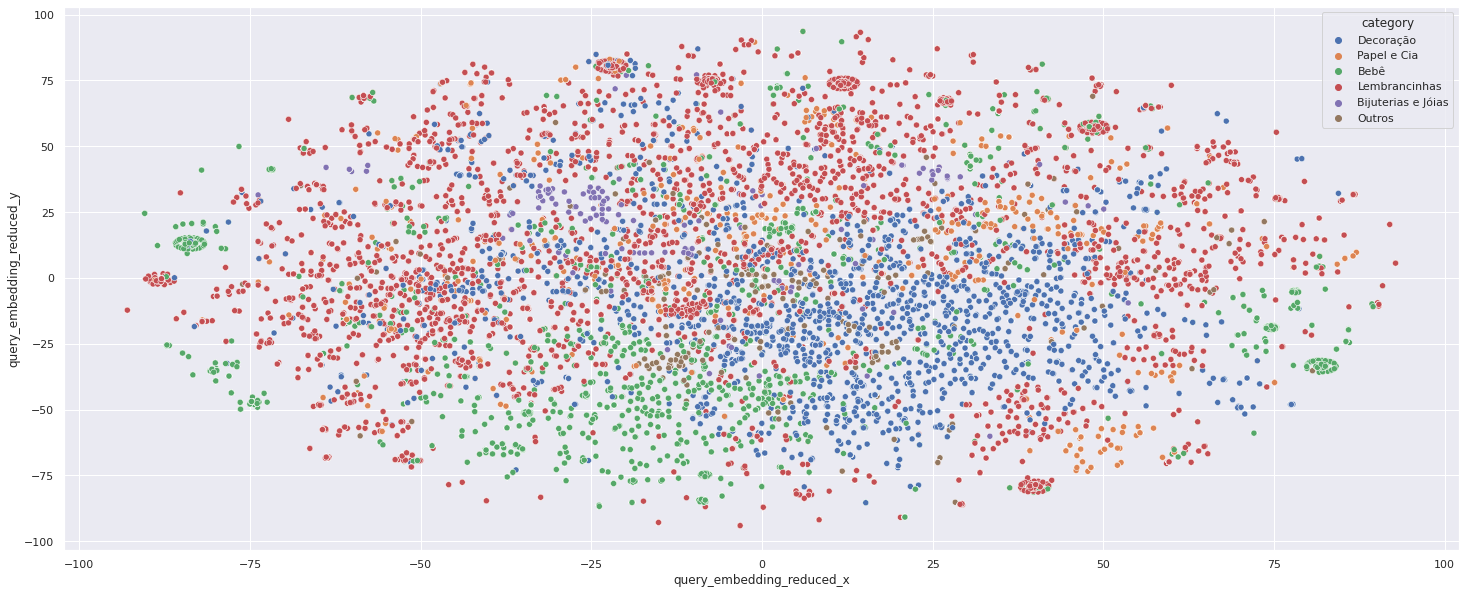

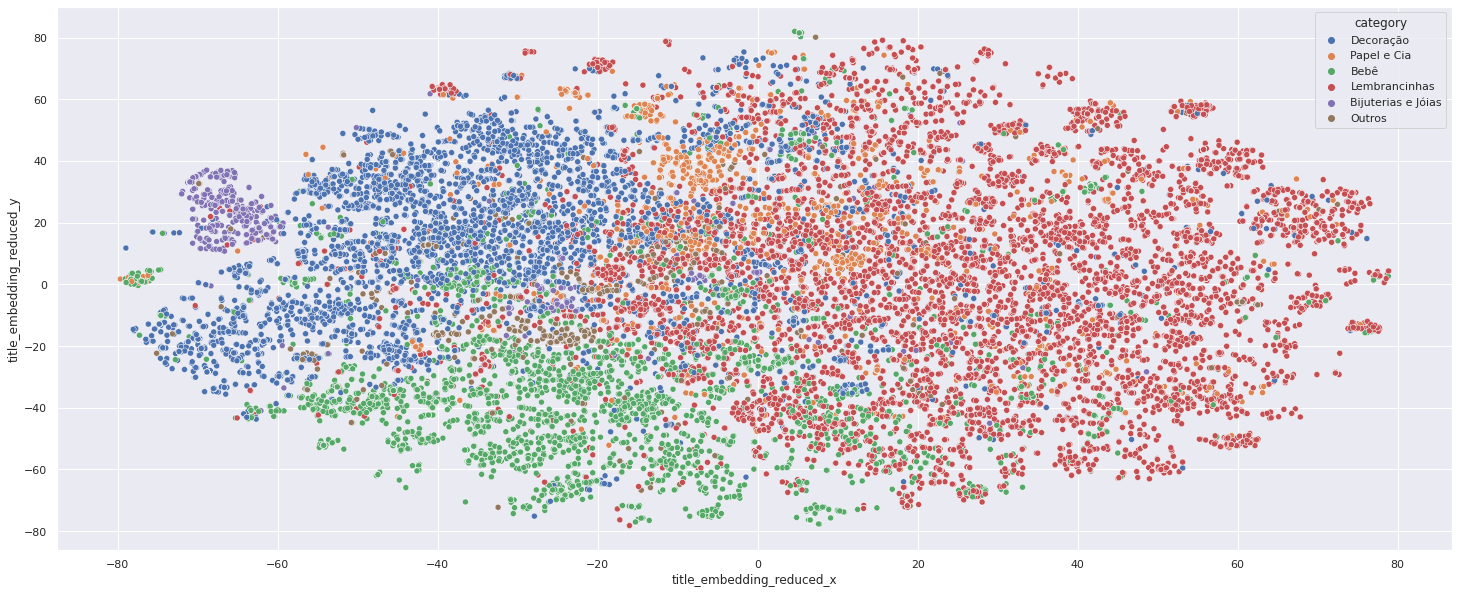

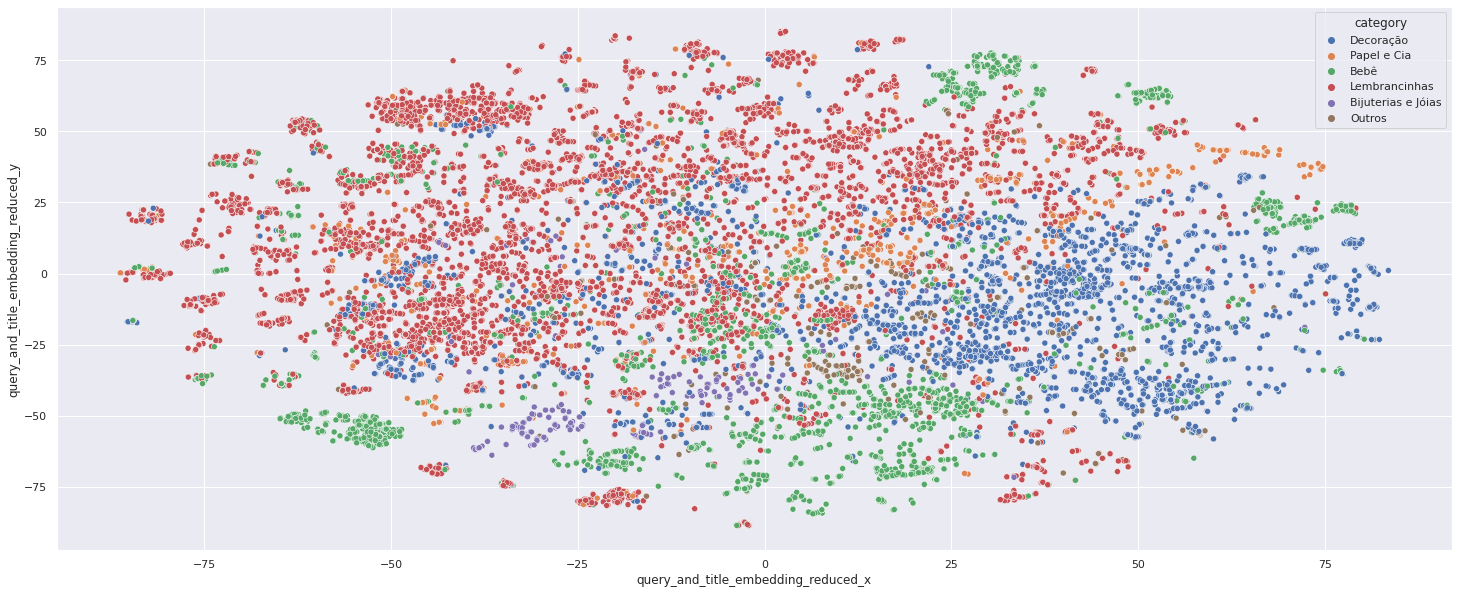

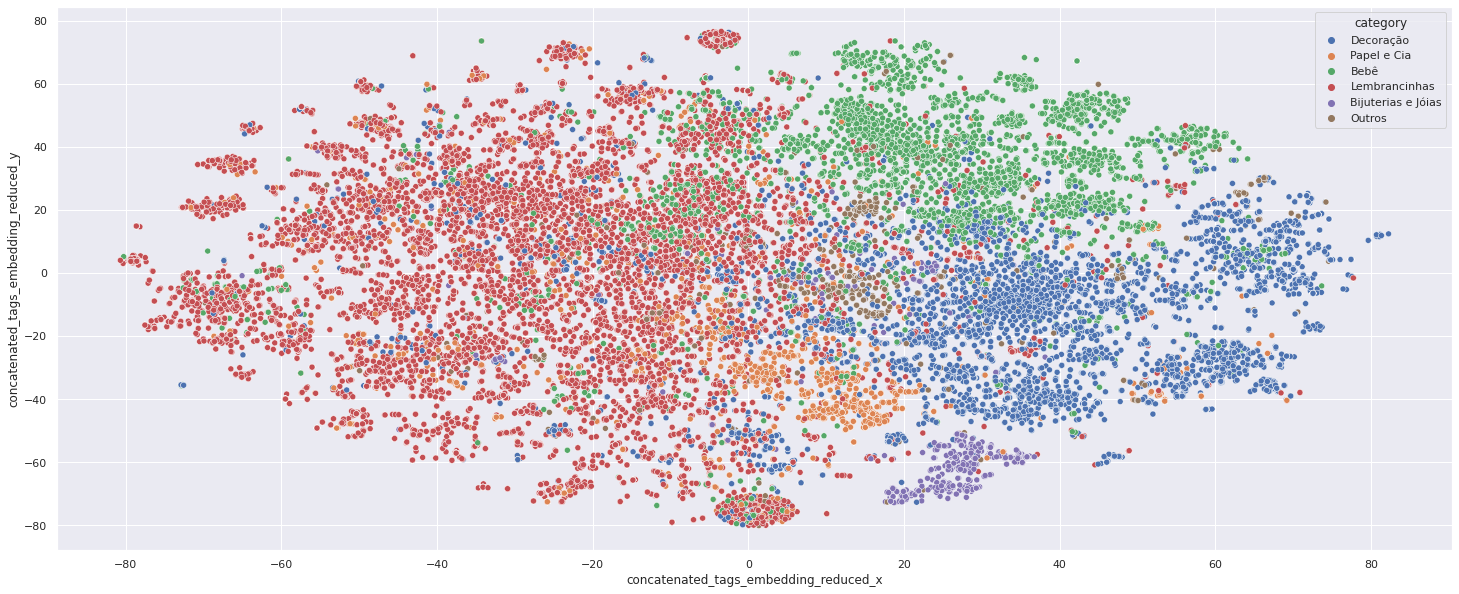

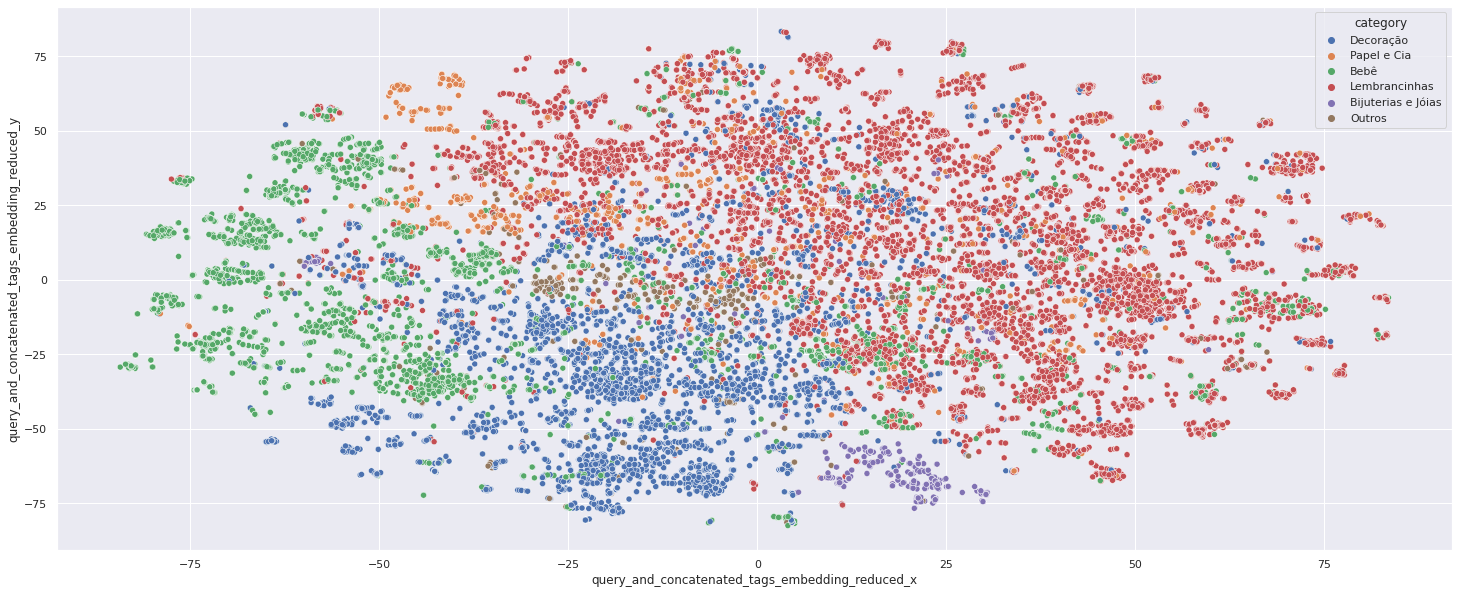

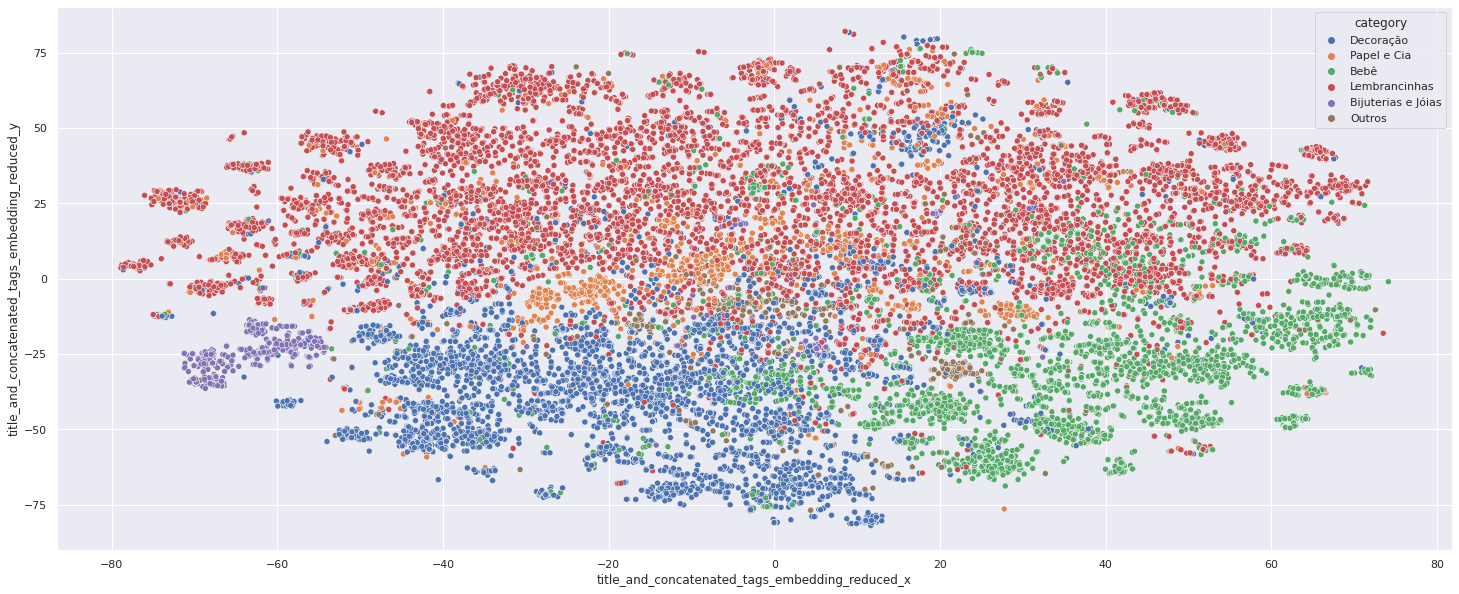

In [12]:
def plot_category_embeddings(base_frame: pd.DataFrame, x_column: str, y_column: str, title: str = None) -> None: 
    if title:
        formatted_column = ' '.join([item.capitalize() for item in title.split('_')])
        display(HTML(f'<h3>{formatted_column}</h3>'))

    g = sns.scatterplot(x=x_column, y=y_column, data=base_frame, hue="category")
    plt.show()

# Extrai a lista de colunas com embeddings criados
embeddings_columns = set([column.split('_embedding_reduced')[0]
                          for column in embeddings_frame.columns 
                          if 'embedding_reduced' in column])

# Ordena colunas extraídas por tamanho, para manter ordem de atômico para composto
embeddings_columns = sorted(embeddings_columns, key=lambda ec: len(ec))

for column in embeddings_columns:
    plot_category_embeddings(embeddings_frame,
                             f'{column}_embedding_reduced_x',
                             f'{column}_embedding_reduced_y',
                             column
                            )

Pelos gráficos, pode-se notar que *título*, *tags concatenadas* e a combinação de ambas permitem fazer agrupamento mais homogênos das categorias. Ainda há regiões em que diferentes categorias ocorrem juntas, o que pode ser pela noção de que produtos poderiam percenter a diferentes categorias, mas a utilização desses vetores pode beneficiar o modelo de classificação.

### Análise de Potencial de Predição da Similaridade

Além de poder construir vetores de características a partir do conteúdo das colunas textuais, uma possibilidade é ver o quão bem os *embeddings* conseguiriam determinar uma categoria a partir do valor da similaridade. Para isso, é possível calcular a similaridade de um determinado valor de coluna textual com o nome de cada categoria disponível. 

In [13]:
embeddings_frame.head(2)

product_id             query  search_page  position  \
0    11394449    espirito santo            2         6   
1    15534262  cartao de visita            2         0   

                    title  \
0  Mandala Espírito Santo   
1        Cartão de Visita   

                                               concatenated_tags  \
0                                                    mandala mdf   
1  cartao visita panfletos tag adesivos copos long drink canecas   

         creation_date     category  \
0  2015-11-14 19:42:12    Decoração   
1  2018-04-04 20:55:07  Papel e Cia   

                                                                                                                                         query_embedding  \
0  [0.004229284, -0.027336909, 0.030303514, 0.069929294, 0.020897388, -0.06250459, 0.050103087, -0.058517657, -0.08247556, -0.11175527, -0.06378104, ...   
1  [-0.026694268, -0.017967489, 0.033112615, 0.014724638, -0.05641233, -0.075842515, -0.024225041, -0.01875468, 0.020485003, -0.0123114195, 0.0144400...   

                                                                                                                                         title_embedding  \
0  [-0.008050227, -0.008805177, 0.05007785, 0.052670166, -0.008375991, -0.08733791, 0.08137107, -0.047023904, -0.084045015, -0.114914, -0.015285425, ...   
1  [-0.045109227, -0.025397679, 0.03495742, 0.0006268186, -0.058263194, -0.07574056, -0.011842876, -0.024876617, 0.008490498, -0.011903388, 0.0148019...   

                                                                                                                             concatenated_tags_embedding  \
0  [-0.00096480176, 0.007755412, 0.055970505, -0.0019719256, -0.019442834, -0.06424611, -0.054305594, 0.016148726, -0.004429266, -0.011865409, 0.0453...   
1  [-0.02545547, -0.014808218, 0.03331411, 0.001733836, -0.045117356, -0.026859686, -0.040624473, -0.008041078, 0.018792158, -0.03884597, 0.044826254...   

                                                                                                                                      category_embedding  \
0  [0.03335538, -0.009606168, 0.027740682, 0.013398484, -0.051526476, -0.15837763, 0.0195394, 0.046819117, 0.0717224, -0.06745236, 0.078372635, -0.06...   
1  [-0.030820217, -0.006388064, 0.005519252, 0.023567379, 0.0053899265, -0.09332599, -0.02573134, -0.018315505, -0.015907828, -0.013604142, 0.0005968...   

   query_embedding_reduced_x  query_embedding_reduced_y  \
0                 -21.589106                  18.745832   
1                  -0.010807                  23.913006   

   title_embedding_reduced_x  title_embedding_reduced_y  \
0                  28.564636                 -33.832130   
1                 -23.811485                  63.148888   

   concatenated_tags_embedding_reduced_x  \
0                               8.687884   
1                             -15.498650   

   concatenated_tags_embedding_reduced_y  query_and_title_embedding_reduced_x  \
0                             -16.507315                           -16.153551   
1                             -26.581007                             5.011244   

   query_and_title_embedding_reduced_y  \
0                           -24.264709   
1                             7.668461   

   query_and_concatenated_tags_embedding_reduced_x  \
0                                        13.508450   
1                                       -39.040237   

   query_and_concatenated_tags_embedding_reduced_y  \
0                                        -9.202456   
1                                        26.725653   

   title_and_concatenated_tags_embedding_reduced_x  \
0                                        20.049038   
1                                        15.960790   

   title_and_concatenated_tags_embedding_reduced_y  
0                                        -8.908418  
1                                        -9.466347

O primeiro passo é representar o nome das categorias como *embeddings*.

In [14]:
encoded_embeddings = []
for category in embeddings_frame['category'].unique().tolist():
    for column in TEXT_COLUMNS:
        embeddings = np.array(ft_model.get_sentence_vector(category.lower()))
        encoded_embeddings.append((category, column, embeddings))

category_name_embedding_frame = pd.DataFrame(encoded_embeddings, columns=['category', 'column', 'embeddings'])
display(HTML(f'<h3>Embeddings dos Registros por cada Categoria e Coluna</h3>'))
display(category_name_embedding_frame)

category             column  \
0            Decoração              query   
1            Decoração              title   
2            Decoração  concatenated_tags   
3          Papel e Cia              query   
4          Papel e Cia              title   
5          Papel e Cia  concatenated_tags   
6                 Bebê              query   
7                 Bebê              title   
8                 Bebê  concatenated_tags   
9        Lembrancinhas              query   
10       Lembrancinhas              title   
11       Lembrancinhas  concatenated_tags   
12  Bijuterias e Jóias              query   
13  Bijuterias e Jóias              title   
14  Bijuterias e Jóias  concatenated_tags   
15              Outros              query   
16              Outros              title   
17              Outros  concatenated_tags   

                                                                                                                                               embeddings  
0   [0.03335538, -0.009606168, 0.027740682, 0.013398484, -0.051526476, -0.15837763, 0.0195394, 0.046819117, 0.0717224, -0.06745236, 0.078372635, -0.06...  
1   [0.03335538, -0.009606168, 0.027740682, 0.013398484, -0.051526476, -0.15837763, 0.0195394, 0.046819117, 0.0717224, -0.06745236, 0.078372635, -0.06...  
2   [0.03335538, -0.009606168, 0.027740682, 0.013398484, -0.051526476, -0.15837763, 0.0195394, 0.046819117, 0.0717224, -0.06745236, 0.078372635, -0.06...  
3   [-0.030820217, -0.006388064, 0.005519252, 0.023567379, 0.0053899265, -0.09332599, -0.02573134, -0.018315505, -0.015907828, -0.013604142, 0.0005968...  
4   [-0.030820217, -0.006388064, 0.005519252, 0.023567379, 0.0053899265, -0.09332599, -0.02573134, -0.018315505, -0.015907828, -0.013604142, 0.0005968...  
5   [-0.030820217, -0.006388064, 0.005519252, 0.023567379, 0.0053899265, -0.09332599, -0.02573134, -0.018315505, -0.015907828, -0.013604142, 0.0005968...  
6   [0.018979523, -0.040133532, 0.0026649132, -0.103634745, 0.033859685, -0.054708503, 0.020257464, 0.05290821, 0.05296137, -0.063500494, 0.038083736,...  
7   [0.018979523, -0.040133532, 0.0026649132, -0.103634745, 0.033859685, -0.054708503, 0.020257464, 0.05290821, 0.05296137, -0.063500494, 0.038083736,...  
8   [0.018979523, -0.040133532, 0.0026649132, -0.103634745, 0.033859685, -0.054708503, 0.020257464, 0.05290821, 0.05296137, -0.063500494, 0.038083736,...  
9   [0.0072319885, -0.068255894, 0.008115664, -0.035704367, -0.08738353, -0.03908668, -0.034679625, -0.002955751, 0.04695147, 0.08704281, 0.049177937,...  
10  [0.0072319885, -0.068255894, 0.008115664, -0.035704367, -0.08738353, -0.03908668, -0.034679625, -0.002955751, 0.04695147, 0.08704281, 0.049177937,...  
11  [0.0072319885, -0.068255894, 0.008115664, -0.035704367, -0.08738353, -0.03908668, -0.034679625, -0.002955751, 0.04695147, 0.08704281, 0.049177937,...  
12  [0.030716147, 0.008908771, -0.0066974135, 0.012140344, -0.016977442, -0.041606173, 0.029939262, 0.019096132, -0.014908142, 0.029624065, -0.0019034...  
13  [0.030716147, 0.008908771, -0.0066974135, 0.012140344, -0.016977442, -0.041606173, 0.029939262, 0.019096132, -0.014908142, 0.029624065, -0.0019034...  
14  [0.030716147, 0.008908771, -0.0066974135, 0.012140344, -0.016977442, -0.041606173, 0.029939262, 0.019096132, -0.014908142, 0.029624065, -0.0019034...  
15  [-0.014617172, -0.07638426, 0.030546945, -0.032391712, 0.042365387, 0.04000781, 0.036864918, 0.0059358235, -0.11796135, -0.14450769, -0.0071384436...  
16  [-0.014617172, -0.07638426, 0.030546945, -0.032391712, 0.042365387, 0.04000781, 0.036864918, 0.0059358235, -0.11796135, -0.14450769, -0.0071384436...  
17  [-0.014617172, -0.07638426, 0.030546945, -0.032391712, 0.042365387, 0.04000781, 0.036864918, 0.0059358235, -0.11796135, -0.14450769, -0.0071384436...

A seguir, faz-se a análise de similaridade entre as representações vetoriais dos nomes das categorias com cada um dos valores das colunas textuais. Para ver o quão eficaz essa similaridade é, a categoria mais similar ao conteúdo comparado é determinada como a classe do registro. Em seguida, as "predições" de categorias são comparadas com a categoria oficial do produto, para que se possa identificar a eficácia da similaridade e o potencial preditivo de cada atributo.

In [15]:
def compute_column_category_similarity(base_embeddings_frame: pd.DataFrame, 
                                       base_categories_embeddings: pd.DataFrame, 
                                       column: str, 
                                       embeddings_column: str,
                                       apply_softmax: bool = False) -> pd.DataFrame:

    similarity_frame = base_embeddings_frame.copy()
    categories = base_embeddings_frame['category'].unique().tolist()
    similarity_columns = [f'similarity_{category.lower().replace(" ", "_")}' for category in categories]

    similarities_list = []
    for category in categories:
        column_embeddings = np.stack(similarity_frame[f'{selected_column}_embedding'].to_numpy(), axis=0)
        category_embedding = (base_categories_embeddings
                              .loc[lambda f: (f['category'] == category) & (f['column'] == column)]
                              [embeddings_column]
                              .iloc[0]                              
                             )
        category_embedding = np.expand_dims(category_embedding, axis=0)

        similarities_list.append(cosine_similarity(category_embedding, column_embeddings))

    if apply_softmax:
        similarity_frame[similarity_columns] = softmax(np.concatenate(similarities_list, axis=0), axis=0).T
    else:
        similarity_frame[similarity_columns] = np.concatenate(similarities_list, axis=0).T

    return similarity_frame

# Criar índices e indice invertido de posição e categoria 
category_indexes = {item:i for i, item in enumerate(embeddings_frame['category'].unique().tolist())}
inverted_category_indexes = {v:k for k, v in category_indexes.items()}

# Compor nome da coluna de similaridade para cada categoria
similarity_columns = [f'similarity_{category.lower().replace(" ", "_")}'
                          for category in embeddings_frame['category'].unique().tolist()]

predictions_by_category_name = []

for selected_column in TEXT_COLUMNS:

    # Calcular similaridades, indenficar o maior valor e o índice do maior valor de similaridade entre categorias
    similarity_frame = compute_column_category_similarity(embeddings_frame, 
                                                          category_name_embedding_frame,
                                                          selected_column,
                                                          'embeddings',
                                                          apply_softmax=False)
    similarity_frame = (similarity_frame
                        .assign(max_sim=lambda f: f[similarity_columns].apply(np.max, axis=1))
                        .assign(pred=lambda f: f[similarity_columns].apply(np.argmax, axis=1))
                       )

    # Formatar e apresentar resultados
    display(HTML(f'<h3><strong>{" ".join([item.capitalize() for item in selected_column.split("_")])}</strong></h3>'))
    display(similarity_frame
     [['title', selected_column, 'category', 'max_sim', 'pred'] + similarity_columns]
     .sample(10)
     .sort_values(by='max_sim', ascending=False)
    )

    # Calcular métricas de classificação multiclass usando a categoria com maior similaridade
    classification_metrics = compute_multiclass_classification_metrics(
        similarity_frame['category'].map(category_indexes),
        similarity_frame['pred']
    )
    
    # Calcular média da métricas aplicadas entre as categorias, para ter métrica global
    metrics_frame = (pd.DataFrame(classification_metrics)
                     .assign(category=lambda f: f.index.map(inverted_category_indexes))
                     .assign(features=selected_column)
                    )
    predictions_by_category_name.append(metrics_frame)

    display_side_by_side(
        [metrics_frame, pd.DataFrame(metrics_frame.drop(columns=['category']).mean(axis=0)).T],
        ['Métricas por Categoria', 'Média das Métricas']
    )
    

title  \
26827                        Caixa lembrança Padre/Pastor(a)   
32665                                Fraldas pintadas menino   
3151                              Lembrancinha chá de panela   
9182                   Bolsinha necessaire Flamingo Tropical   
32341                            CHAVEIRO GIRATÓRIO meia lua   
20185                 Saída Maternidade Bata Laço Verde Agua   
22533  Caixa para marshmallows Unicórnio com nome da criança   
17031                              Convite de Chá de bebê II   
23527          Planta Artificial CEREJEIRA SAKURA 2,0 metros   
25798                          Chinelos de Casamento 2ªlinha   

                                query       category   max_sim  pred  \
26827         lembrancinha para padre  Lembrancinhas  0.613931     3   
32665    fraldas pintadas para menino           Bebê  0.613494     2   
3151       lembrancinha cha de panela  Lembrancinhas  0.564539     3   
9182                   festa flamingo  Lembrancinhas  0.514139     0   
32341  lembrancinha dia dos pais meia  Lembrancinhas  0.512067     3   
20185     saida de maternidade menina           Bebê  0.457248     2   
22533                 festa unicornio  Lembrancinhas  0.454562     0   
17031                     cha de bebe           Bebê  0.430678     2   
23527             plantas artificiais      Decoração  0.394828     4   
25798                         chinelo  Lembrancinhas  0.250824     4   

       similarity_decoração  similarity_papel_e_cia  similarity_bebê  \
26827              0.386209                0.271547         0.386343   
32665              0.367882                0.338013         0.613494   
3151               0.392058                0.336512         0.327012   
9182               0.514139                0.191492         0.342924   
32341              0.349275                0.320700         0.465539   
20185              0.320093                0.350551         0.457248   
22533              0.454562                0.221224         0.299347   
17031              0.254489                0.343429         0.430678   
23527              0.330566                0.243869         0.230705   
25798              0.154511                0.210320         0.233565   

       similarity_lembrancinhas  similarity_bijuterias_e_jóias  \
26827                  0.613931                       0.249328   
32665                  0.462338                       0.370066   
3151                   0.564539                       0.307165   
9182                   0.416474                       0.264503   
32341                  0.512067                       0.257744   
20185                  0.315173                       0.278410   
22533                  0.383387                       0.220111   
17031                  0.315801                       0.254335   
23527                  0.310782                       0.394828   
25798                  0.228364                       0.250824   

       similarity_outros  
26827           0.197881  
32665           0.242777  
3151            0.041137  
9182            0.141864  
32341           0.403377  
20185           0.132358  
22533           0.106255  
17031           0.063938  
23527           0.331900  
25798           0.097935

title  \
9653                              Saquinho maternidade   
22985             Lembrancinha aniversario 90 anos imã   
19979                 BRINDE PARA CONVIDADOS CASAMENTO   
29844   Lembrancinha Moana Copo com tampa 500 ml Moana   
20144  alça bolsa couro legítimo preto com porta alcas   
30934           Chinelo Personalizado Mulher Maravilha   
18014                  Mochila Personalizada miráculos   
4623                                3 Tapete em croche   
17281               Pen Drive Personalizado 4GB Pico A   
9699                               Letras 3d Motocross   

                                                 title       category  \
9653                              Saquinho maternidade           Bebê   
22985             Lembrancinha aniversario 90 anos imã  Lembrancinhas   
19979                 BRINDE PARA CONVIDADOS CASAMENTO  Lembrancinhas   
29844   Lembrancinha Moana Copo com tampa 500 ml Moana  Lembrancinhas   
20144  alça bolsa couro legítimo preto com porta alcas         Outros   
30934           Chinelo Personalizado Mulher Maravilha  Lembrancinhas   
18014                  Mochila Personalizada miráculos  Lembrancinhas   
4623                                3 Tapete em croche      Decoração   
17281               Pen Drive Personalizado 4GB Pico A  Lembrancinhas   
9699                               Letras 3d Motocross  Lembrancinhas   

        max_sim  pred  similarity_decoração  similarity_papel_e_cia  \
9653   0.596720     2              0.344009                0.284851   
22985  0.557670     3              0.317714                0.224371   
19979  0.510986     3              0.434855                0.292549   
29844  0.461003     3              0.324512                0.317519   
20144  0.453080     4              0.308201                0.365291   
30934  0.447205     2              0.385395                0.345219   
18014  0.408001     3              0.388284                0.258065   
4623   0.378089     4              0.232899                0.283861   
17281  0.349680     1              0.122878                0.349680   
9699   0.347880     4              0.268062                0.257544   

       similarity_bebê  similarity_lembrancinhas  \
9653          0.596720                  0.525563   
22985         0.337830                  0.557670   
19979         0.358985                  0.510986   
29844         0.311015                  0.461003   
20144         0.351752                  0.299838   
30934         0.447205                  0.352951   
18014         0.374784                  0.408001   
4623          0.216753                  0.229622   
17281         0.186479                  0.211391   
9699          0.147367                  0.286805   

       similarity_bijuterias_e_jóias  similarity_outros  
9653                        0.307898           0.140574  
22985                       0.222337           0.179004  
19979                       0.261655           0.328464  
29844                       0.304488           0.180247  
20144                       0.453080           0.248512  
30934                       0.333021           0.179229  
18014                       0.357076           0.237450  
4623                        0.378089           0.111169  
17281                       0.245529           0.084921  
9699                        0.347880           0.106601

title  \
20977                              Lembrancinha de Chá de Cozinha   
20015            Festa de 15 anos / Saquinho de TNT personalizado   
15279                                        CHINELO DIA DOS PAIS   
28418                                      NINHO REDUTOR DE BERÇO   
3929                                         Taças personalizadas   
14091               Aplique/adesivo/tag - Cassino - carta baralho   
6883               Lembrancinha casamento aromatizador de varetas   
31093                      Adesivo De Vitrine Dia Dos Pais Oculos   
19051                                       Centro de mesa Minnie   
14361  Lembrancinhas para Festividade na Igreja; Evento Religioso   

                                                                          concatenated_tags  \
20977                              presentes lembrancinhas lembran lembrancinha cha cozinha   
20015  lembrancas lembrancinhas casamento lembrancinha duda faz 15 canecas acrilico 15 anos   
15279                                chinelos personalizados dia pais diversos lembrancinha   
28418                       bb ninho boy ninhos menino caetano berco theo bebe filho ninhos   
3929                                                 casamento tacas avulsas personalizadas   
14091         festa cassino las vegas niver aninha apliques adesivos tags papel fotografico   
6883                                                         casamento aromatizador difusor   
31093                                                      dia pais adesivo vitrine adesivo   
19051                                           centro mesa aniversario 5 anos minnie mafer   
14361                                                                                igreja   

            category   max_sim  pred  similarity_decoração  \
20977  Lembrancinhas  0.802809     3              0.561033   
20015  Lembrancinhas  0.713232     3              0.463529   
15279  Lembrancinhas  0.629447     3              0.462029   
28418           Bebê  0.625472     2              0.240723   
3929   Lembrancinhas  0.590547     3              0.440199   
14091    Papel e Cia  0.566368     3              0.474448   
6883   Lembrancinhas  0.473283     0              0.473283   
31093    Papel e Cia  0.468938     2              0.414386   
19051  Lembrancinhas  0.441968     3              0.384586   
14361  Lembrancinhas  0.312625     0              0.312625   

       similarity_papel_e_cia  similarity_bebê  similarity_lembrancinhas  \
20977                0.325393         0.405063                  0.802809   
20015                0.274754         0.357996                  0.713232   
15279                0.309897         0.448014                  0.629447   
28418                0.269419         0.625472                  0.287467   
3929                 0.286330         0.291076                  0.590547   
14091                0.400403         0.336763                  0.566368   
6883                 0.257831         0.385554                  0.413117   
31093                0.313172         0.468938                  0.406463   
19051                0.261347         0.361485                  0.441968   
14361                0.155434         0.182069                  0.209322   

       similarity_bijuterias_e_jóias  similarity_outros  
20977                       0.371488           0.201174  
20015                       0.408055           0.250136  
15279                       0.371656           0.493115  
28418                       0.218532           0.193771  
3929                        0.477942           0.223930  
14091                       0.398007           0.230378  
6883                        0.242019           0.155956  
31093                       0.268103           0.235202  
19051                       0.280556           0.219043  
14361                       0.181724           0.147459

Pela avaliação superficial desse classificador ingênuo, título e consulta teriam um desempenho próximo, com aproximadamente 0.35 de precisão e F1, enquanto a concatenação das tags teria a eficácia maior, com 0.38 de precisão e 0.40 de F1. 

Algo recorrente que pôde ser observado no dataset é não concordância entre tags e categorias. Na tabela abaixo, é possível observar casos em que a categoria é diferente de 'Lembrancinhas', mas a única tag associada ao produto indica exatamente o conteúdo 'Lembrancinhas'. Ainda que isso seja incoerente do ponto de vista de categorização, para o vendedor faz sentido aplicar uma tag diferente da categoria para ampliar a possibilidade de seu produto casar com termos de busca de clientes.

In [16]:
(similarity_frame
 [['concatenated_tags', 'category', 'max_sim']]
 .sort_values(by='max_sim', ascending=False)
 .head()
)

concatenated_tags       category  max_sim
17623     lembrancinhas  Lembrancinhas      1.0
13979     lembrancinhas    Papel e Cia      1.0
9554      lembrancinhas           Bebê      1.0
16003     lembrancinhas  Lembrancinhas      1.0
4955      lembrancinhas           Bebê      1.0

Para tentar evitar uma dependência mais direta e essencialmente sintática entre categoria e as demais colunas textuais, a seguir é feita uma tentativa de generalização do conteúdo de cada categoria. Para isso, usa-se como *embeddings* da categoria não o nome da categoria, mas a média dos *embeddings* dos produtos que pertencem à categoria.

In [17]:
encoded_embeddings = []
for category in embeddings_frame['category'].unique().tolist():
    for column in TEXT_COLUMNS:
        embeddings = np.stack(embeddings_frame
                              .loc[lambda f: f['category'] == category]
                              [f'{column}_embedding']
                              .to_numpy(),
                              axis=0)
        encoded_embeddings.append((category, column, np.mean(embeddings, axis=0)))        

average_embedding_frame = pd.DataFrame(encoded_embeddings, columns=['category', 'column', 'averaged_embeddings'])
display(HTML(f'<h3>Média dos Embeddings dos Registros por cada Categoria e Coluna</h3>'))
average_embedding_frame

category             column  \
0            Decoração              query   
1            Decoração              title   
2            Decoração  concatenated_tags   
3          Papel e Cia              query   
4          Papel e Cia              title   
5          Papel e Cia  concatenated_tags   
6                 Bebê              query   
7                 Bebê              title   
8                 Bebê  concatenated_tags   
9        Lembrancinhas              query   
10       Lembrancinhas              title   
11       Lembrancinhas  concatenated_tags   
12  Bijuterias e Jóias              query   
13  Bijuterias e Jóias              title   
14  Bijuterias e Jóias  concatenated_tags   
15              Outros              query   
16              Outros              title   
17              Outros  concatenated_tags   

                                                                                                                                      averaged_embeddings  
0   [-0.007964056, -0.014651332, 0.038455818, 0.01766196, -0.019800413, -0.05913129, -0.00073482434, -0.006100115, 0.012117426, -0.042138804, 0.023452...  
1   [-0.004499731, -0.011117094, 0.039307337, 0.0087564085, -0.014077116, -0.056779742, 0.000126013, -0.007247141, 0.00651129, -0.03627611, 0.01994321...  
2   [-0.003190069, -0.0072633135, 0.04421958, 0.019958705, -0.022145906, -0.05130182, -0.0014365015, -0.0067820707, 0.009300181, -0.04913421, 0.033625...  
3   [-0.018732795, -0.034160767, 0.031822205, 0.00013541491, -0.014886948, -0.06099686, -0.018668389, -0.011273392, 0.0061525726, -0.04201865, 0.01188...  
4   [-0.015145668, -0.028174656, 0.032744106, 5.9342045e-05, -0.014411121, -0.056480847, -0.015982574, -0.011586429, 0.0010866959, -0.035746813, 0.008...  
5   [-0.019253427, -0.031899285, 0.038944308, -0.0004987191, -0.022371858, -0.051442973, -0.021818992, -0.012410783, 0.0008249664, -0.04216691, 0.0213...  
6   [-0.0087795565, -0.03314465, 0.03674917, -0.014080777, -0.011695282, -0.06567188, 0.008216412, -0.014336072, 0.018310852, -0.046924997, 0.01165069...  
7   [-0.0073604425, -0.024197565, 0.036609806, -0.01523442, -0.0138698295, -0.059848763, 0.0077545196, -0.01129135, 0.00907282, -0.041313305, 0.011608...  
8   [-0.0039862837, -0.028009303, 0.03580334, -0.016909296, -0.01588895, -0.05017016, 0.007285881, -0.01181218, 0.022165973, -0.045713436, 0.02822259,...  
9   [-0.017055836, -0.03519711, 0.027647054, -0.017203981, -0.015325613, -0.04968543, -0.0066670375, -0.0145172365, 0.02349838, -0.03376357, 0.0094938...  
10  [-0.019107373, -0.032837156, 0.031193515, -0.016760847, -0.011787891, -0.051410615, -0.007494227, -0.015155565, 0.018061334, -0.035386745, 0.00935...  
11  [-0.017429171, -0.028819654, 0.032151338, -0.015874082, -0.018296452, -0.042937644, -0.005982747, -0.013096246, 0.021520954, -0.033662267, 0.02036...  
12  [-0.0038209166, -0.04604494, 0.027318906, -0.0012207765, -0.029347682, -0.052213088, 0.009443185, 0.016198652, 0.0051921885, -0.041516084, 0.02527...  
13  [-0.0015582911, -0.026164884, 0.035279237, 0.0014471235, -0.019884564, -0.05579568, 0.011767248, 0.010612631, -0.0002484724, -0.034101512, 0.02079...  
14  [0.00052918197, -0.034913577, 0.031923138, 0.0020718088, -0.032644596, -0.039635308, 0.011054089, 0.019549584, 0.00033726598, -0.037580993, 0.0277...  
15  [-0.007516479, -0.040242624, 0.034904268, -0.0035694712, -0.020783562, -0.048479754, -0.007302867, -0.0130349, 0.01363995, -0.03901185, 0.00965969...  
16  [-0.007872141, -0.02988408, 0.036828358, -0.0016022709, -0.016604465, -0.046406545, -0.0031431727, -0.011842724, 0.003404722, -0.03532482, 0.00846...  
17  [-0.006706863, -0.036492076, 0.04244292, -0.0011504192, -0.02528769, -0.036502734, -0.005838739, -0.013257201, 0.0048519433, -0.038909223, 0.01967...

In [18]:
# Criar índices e indice invertido de posição e categoria 
category_indexes = {item:i for i, item in enumerate(embeddings_frame['category'].unique().tolist())}
inverted_category_indexes = {v:k for k, v in category_indexes.items()}

# Compor nome da coluna de similaridade para cada categoria
similarity_columns = [f'similarity_{category.lower().replace(" ", "_")}'
                          for category in embeddings_frame['category'].unique().tolist()]

predictions_by_category_content = []
for selected_column in TEXT_COLUMNS:

    # Calcular similaridades, indenficar o maior valor e o índice do maior valor de similaridade entre categorias
    similarity_frame = compute_column_category_similarity(embeddings_frame, 
                                                          average_embedding_frame,
                                                          selected_column, 
                                                          'averaged_embeddings',
                                                          apply_softmax=False)
    similarity_frame = (similarity_frame
                        .assign(max_sim=lambda f: f[similarity_columns].apply(np.max, axis=1))
                        .assign(pred=lambda f: f[similarity_columns].apply(np.argmax, axis=1))
                       )

    # Formatar e apresentar resultados
    display(HTML(f'<h3><strong>{" ".join([item.capitalize() for item in selected_column.split("_")])}</strong></h3>'))
    display(similarity_frame
     [['title', selected_column, 'category', 'max_sim', 'pred'] + similarity_columns]
     .sample(10)
     .sort_values(by='max_sim', ascending=False)
    )

    # Calcular métricas de classificação multiclass usando a categoria com maior similaridade
    classification_metrics = compute_multiclass_classification_metrics(
        similarity_frame['category'].map(category_indexes),
        similarity_frame['pred']
    )

    # Calcular média da métricas aplicadas entre as categorias, para ter métrica global
    metrics_frame = (pd.DataFrame(classification_metrics)
                     .assign(category=lambda f: f.index.map(inverted_category_indexes))
                     .assign(features=selected_column)
                    )
    predictions_by_category_content.append(metrics_frame)
    
    display_side_by_side(
        [metrics_frame, pd.DataFrame(metrics_frame.drop(columns=['category']).mean(axis=0)).T],
        ['Métricas por Categoria', 'Média das Métricas']
    )

title                         query  \
18661       Kit Bolsa Maternidade G + Trocador         kit bolsa maternidade   
10413                        porta maternidade             porta maternidade   
13166  Tecido Adesivo xadrez pequeno rosa bebê                tecido adesivo   
12270         lembrancinha de nascimento - ímã   lembrancinhas de nascimento   
16843      Quadro Digital Infantil Festa Circo        quadro quarto infantil   
2659                            Fralda de boca                fralda de boca   
3315        lembrança com ímã tamanho 10x7,5cm  lembrancinha ima tamanho 7x5   
3070                                    Dominó          domino personalizado   
297      DECORAÇÃO COM SUCULENTAS COLORIDAS G.          suculentas coloridas   
13563                            Flâmula Vinho                       flamula   

            category   max_sim  pred  similarity_decoração  \
18661           Bebê  0.810432     2              0.590191   
10413           Bebê  0.716216     2              0.555727   
13166      Decoração  0.692877     5              0.645717   
12270  Lembrancinhas  0.672512     3              0.556995   
16843      Decoração  0.664486     0              0.664486   
2659            Bebê  0.637793     2              0.568634   
3315          Outros  0.633627     3              0.544350   
3070   Lembrancinhas  0.530595     1              0.459338   
297        Decoração  0.496652     0              0.496652   
13563      Decoração  0.461913     4              0.431477   

       similarity_papel_e_cia  similarity_bebê  similarity_lembrancinhas  \
18661                0.660850         0.810432                  0.664100   
10413                0.530769         0.716216                  0.562802   
13166                0.624775         0.582595                  0.545685   
12270                0.605515         0.627844                  0.672512   
16843                0.597786         0.601625                  0.567194   
2659                 0.515027         0.637793                  0.547564   
3315                 0.580961         0.553168                  0.633627   
3070                 0.530595         0.441147                  0.487543   
297                  0.462967         0.365766                  0.432601   
13563                0.391591         0.379203                  0.379721   

       similarity_bijuterias_e_jóias  similarity_outros  
18661                       0.546533           0.654335  
10413                       0.465575           0.521783  
13166                       0.482955           0.692877  
12270                       0.465693           0.553126  
16843                       0.412375           0.513530  
2659                        0.450435           0.615669  
3315                        0.477021           0.575534  
3070                        0.333944           0.465950  
297                         0.375514           0.494761  
13563                       0.461913           0.412350

title  \
12141  Festa Jardim Encantado Lembrancinha Almofada Personalizada   
11196                                       Flor gigante de papel   
4275                 Sabonete de unicórnio lembrancinha unicórnio   
12513                                       Anel prata olho grego   
10594                             Caneca Personalizada Enfermagem   
27981                         Lindo banco que vira mesa/Móveis SC   
10712                                           Porta Maternidade   
25832                                Presente Quadro Dia dos Pais   
27091                                           Quadro MDF Sasuke   
28085                                                Balão Mickey   

                                                            title  \
12141  Festa Jardim Encantado Lembrancinha Almofada Personalizada   
11196                                       Flor gigante de papel   
4275                 Sabonete de unicórnio lembrancinha unicórnio   
12513                                       Anel prata olho grego   
10594                             Caneca Personalizada Enfermagem   
27981                         Lindo banco que vira mesa/Móveis SC   
10712                                           Porta Maternidade   
25832                                Presente Quadro Dia dos Pais   
27091                                           Quadro MDF Sasuke   
28085                                                Balão Mickey   

                 category   max_sim  pred  similarity_decoração  \
12141       Lembrancinhas  0.839122     3              0.710757   
11196           Decoração  0.744711     0              0.744711   
4275        Lembrancinhas  0.739503     3              0.654089   
12513  Bijuterias e Jóias  0.713010     4              0.549622   
10594       Lembrancinhas  0.711093     3              0.586566   
27981           Decoração  0.690016     0              0.690016   
10712                Bebê  0.682303     2              0.533888   
25832           Decoração  0.639607     1              0.588310   
27091           Decoração  0.622982     0              0.622982   
28085       Lembrancinhas  0.578349     3              0.502296   

       similarity_papel_e_cia  similarity_bebê  similarity_lembrancinhas  \
12141                0.737697         0.755234                  0.839122   
11196                0.687786         0.672971                  0.646283   
4275                 0.662539         0.713090                  0.739503   
12513                0.512321         0.490651                  0.493855   
10594                0.650736         0.644096                  0.711093   
27981                0.680782         0.659092                  0.648689   
10712                0.531622         0.682303                  0.564066   
25832                0.639607         0.576957                  0.611604   
27091                0.563141         0.530517                  0.545756   
28085                0.523270         0.526303                  0.578349   

       similarity_bijuterias_e_jóias  similarity_outros  
12141                       0.606713           0.705064  
11196                       0.690775           0.716964  
4275                        0.646700           0.698887  
12513                       0.713010           0.550339  
10594                       0.519138           0.615356  
27981                       0.593351           0.663090  
10712                       0.480877           0.517964  
25832                       0.489420           0.520761  
27091                       0.458922           0.537941  
28085                       0.382713           0.532618

title  \
17319  MESA DE MADEIRA MACIÇA RÚSTICA DECORADA COM CERÂMICA   
27699               Cesto Fio de Malha Quadrado-kit 2 peças   
1370      Kit Montessori para bebês - Brinquedos Montessori   
8515                                   CHINELO DIA DOS PAIS   
3643                      Kit Cine Pipoca - Bodas de Pipoca   
5545                                  Trilho de mesa floral   
11102                          Vestido Bebe Branco Poazinho   
7106                                               fichário   
27307  Vasinho de madeira com arranjo de flores artificiais   
19223                                     Quadro decorativo   

                                                                 concatenated_tags  \
17319  moveis mesas patchwork (decoradas azulejos mesas bancos mesa madeira macica   
27699                                                   cestos fios decoracao bebe   
1370            brinquedos montessori brincadoteca kits bebe brinquedos montessori   
8515                                     chinelos personalizados dia pais diversos   
3643                                           kit bodas bodas presentes criativos   
5545                                                       floral trilho mesa mesa   
11102                             look menina roupa lavinia roupas ofertas vestido   
7106                                               papelaria pranchetas escritorio   
27307                                                   arranjo flores artificiais   
19223                                             quadro quadros quadro decorativo   

            category   max_sim  pred  similarity_decoração  \
17319      Decoração  0.837378     0              0.837378   
27699      Decoração  0.760051     0              0.760051   
1370            Bebê  0.751878     2              0.694050   
8515   Lembrancinhas  0.740949     1              0.674148   
3643   Lembrancinhas  0.733906     3              0.654348   
5545       Decoração  0.699289     0              0.699289   
11102           Bebê  0.699123     5              0.629636   
7106     Papel e Cia  0.677309     1              0.649615   
27307      Decoração  0.624910     0              0.624910   
19223      Decoração  0.619860     0              0.619860   

       similarity_papel_e_cia  similarity_bebê  similarity_lembrancinhas  \
17319                0.675074         0.623683                  0.634224   
27699                0.644463         0.750991                  0.657264   
1370                 0.685188         0.751878                  0.679283   
8515                 0.740949         0.636302                  0.718561   
3643                 0.723219         0.617211                  0.733906   
5545                 0.571859         0.567480                  0.567465   
11102                0.631518         0.697912                  0.654474   
7106                 0.677309         0.530524                  0.566786   
27307                0.553716         0.481915                  0.513096   
19223                0.494783         0.411437                  0.417792   

       similarity_bijuterias_e_jóias  similarity_outros  
17319                       0.626941           0.745454  
27699                       0.591466           0.757688  
1370                        0.515641           0.714272  
8515                        0.566590           0.695610  
3643                        0.621277           0.652972  
5545                        0.506301           0.603711  
11102                       0.653198           0.699123  
7106                        0.458980           0.593237  
27307                       0.538033           0.612643  
19223                       0.344618           0.464494

Com a troca da análise de similaridade pelo conteúdo dos itens da categoria em vez do simples nome da categoria, houve um aumento significativo da eficácia. 

In [19]:
metrics_by_category_name = pd.concat(predictions_by_category_name, axis=0)
metrics_by_category_content = pd.concat(predictions_by_category_content, axis=0)

display_side_by_side([metrics_by_category_name, metrics_by_category_content], ['Name', 'Content'])

TODO (ou devaneios):
 - Verificar tamanho do vocabulário usando TF-IDF 
 - Fazer avaliações de similaridade e busca usando as abordagens em teste
     - Uma estratégia de validação pode ser a correlação entre a página de busca + posição de produtos com a mesma busca com a ordem retornada pela estratégia de trabalho com texto. A busca que deu origem à ordem certamente tem mais recursos, e também não é possível garantir que as buscas sejam da mesma pessoa, mas é algum indício.
 - Avaliar a necessidade de usar pré-processamentos adicionais de texto para o fasttext
 - Reduzir tamanho dos embeddings
 - Avaliar embeddings do BERTimbau